<a href="https://colab.research.google.com/github/joelsoaresjr/python_strategies/blob/main/predict_bova11_rede_neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 7.5 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=8f6438e19cad9d87b3a82160e6242b25441822d668cd7df391b83c43431be006
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


Importação das bibliotecas

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from datetime import date
import yfinance as yf
import seaborn as sns
sns.set(rc={'figure.figsize':(30,14)})
import plotly.express as px

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


import warnings
warnings.filterwarnings('ignore')

Ações escolhidas para prever se amanhã cairá ou subirá a partir da abertura

---




In [3]:
coluna = ['BOVA11', 'ITUB4', 'BBDC4', 'B3SA3', 'PETR4', 'ABEV3', 'PETR3', 'ITSA4', 
          'BBAS3']

ticker = []
for i in range(len(coluna)):
  ticker.append(coluna[i] + '.SA')

Extração das cotações (CLOSE)

In [4]:
start = date(2010,1,1)
end = date(2021,8,1)

In [5]:
dados = yf.download(ticker, start, end)["Adj Close"]
dados.columns = sorted(coluna)
dados.dropna(inplace = True)

[*********************100%***********************]  9 of 9 completed


Variação diária

In [6]:
dados_return = dados.pct_change()

Evoluação dos preços

In [7]:
dados_return_acum = (dados_return + 1 ).cumprod()
dados_return_acum.iloc[0 , :] = 1 

Visualização dos dados

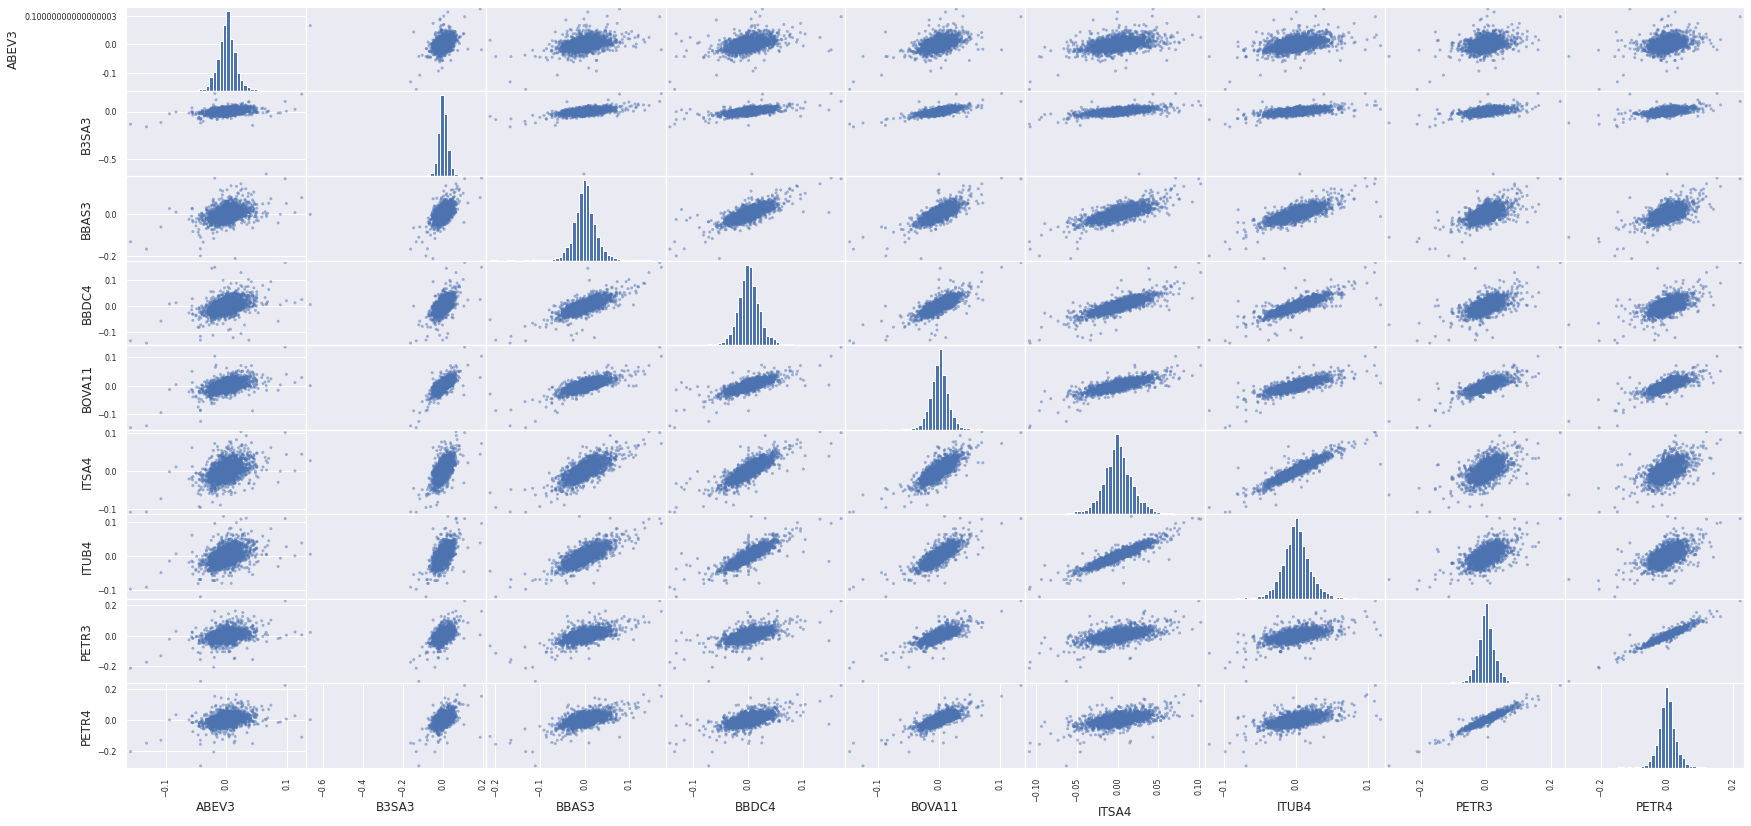

In [8]:
pd.plotting.scatter_matrix(dados_return, figsize = (29, 14), hist_kwds={'bins':50});

In [9]:
sns.set(rc={'figure.figsize':(30,14)})

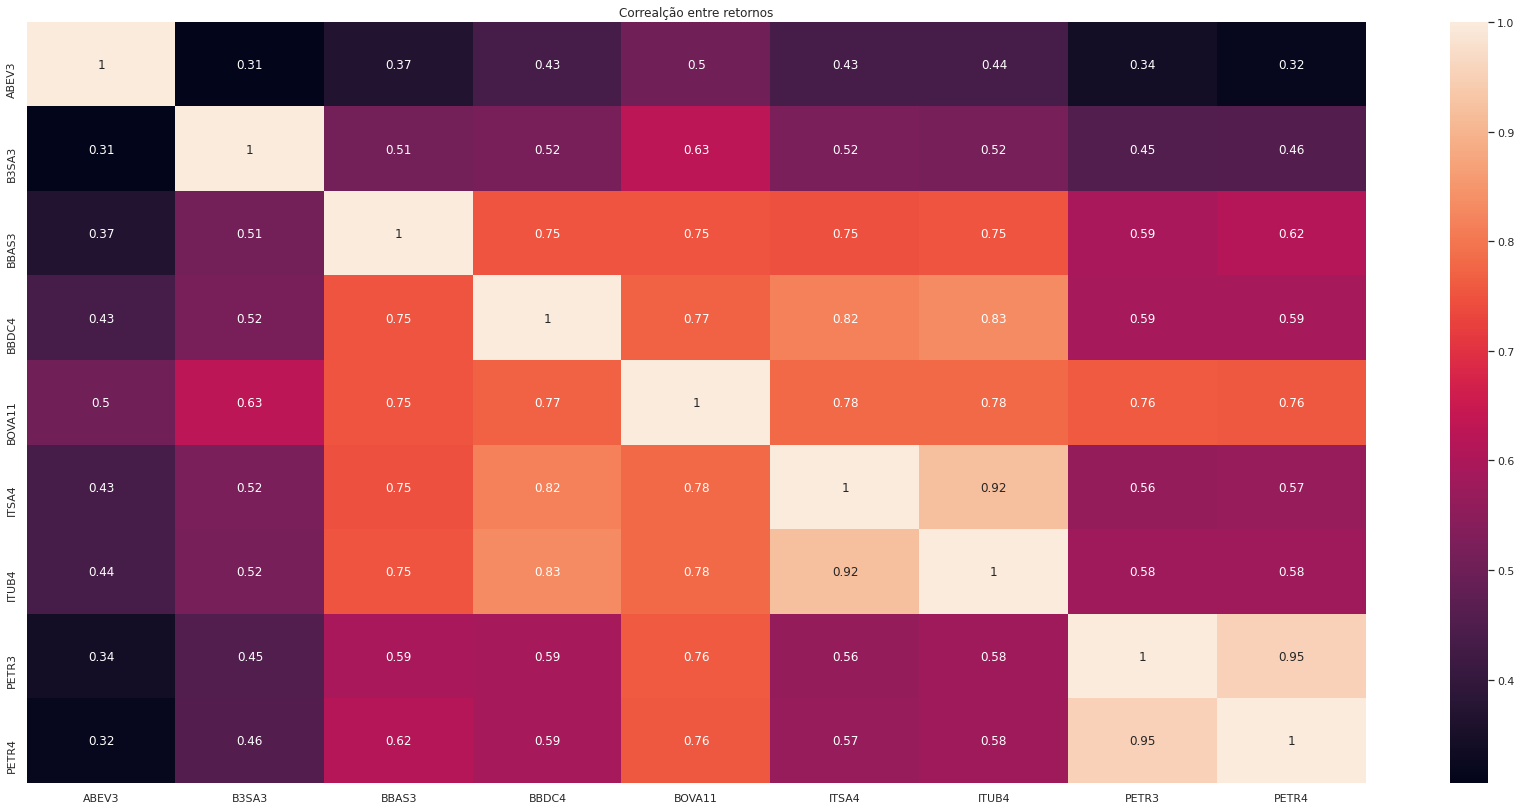

In [10]:
plt.title('Correalção entre retornos')
sns.heatmap(dados_return.corr(), annot = True);

In [11]:
figura1 = px.line(title = 'Histórico do preço das ações')
for i in dados.columns:
  figura1.add_scatter(x = dados.index, y = dados[i], name = i)
figura1.show()

In [12]:
figura2 = px.line(title = 'Evolução do preço das ações')
for i in dados.columns:
  figura2.add_scatter(x = dados_return_acum.index, y = dados_return_acum[i], name = i)
figura2.show()

Previsores

In [13]:
previsores = dados_return.iloc[1: len(dados_return)-1]

In [14]:
previsores

,ABEV3,B3SA3,BBAS3,BBDC4,BOVA11,ITSA4,ITUB4,PETR3,PETR4
Date,,,,,,,,,
2010-01-05,0.005882,0.003861,-0.010033,-0.004956,0.007640,-0.003234,0.006480,-0.006002,-0.008574
2010-01-06,0.010202,0.037692,0.001352,-0.008000,0.005722,-0.012166,-0.008668,0.009904,0.013513
2010-01-07,0.004695,0.023722,0.000337,-0.002688,-0.004267,-0.005747,-0.010243,-0.005979,-0.009333
2010-01-08,-0.001921,-0.023172,0.005734,-0.001078,-0.007429,-0.007432,-0.015144,-0.007459,-0.005384
2010-01-11,-0.012187,0.008896,0.007712,0.000810,0.007340,-0.003328,-0.008713,0.000970,-0.003248
...,...,...,...,...,...,...,...,...,...
2021-07-23,-0.016442,-0.009091,-0.005321,-0.010331,-0.010129,-0.000902,-0.002749,-0.013324,-0.005948
2021-07-26,0.020299,0.003670,0.015418,0.008351,0.008319,0.009025,0.017574,0.020073,0.027300
2021-07-27,-0.009947,-0.018891,0.004648,0.007868,-0.011881,0.006261,0.009820,-0.004293,-0.011649


Valor previsto

In [15]:
classe = dados_return.iloc[2:len(dados_return), 0]

In [16]:
classe

Date
2010-01-06    0.010202
2010-01-07    0.004695
2010-01-08   -0.001921
2010-01-11   -0.012187
2010-01-12    0.006493
                ...   
2021-07-26    0.020299
2021-07-27   -0.009947
2021-07-28    0.024232
2021-07-29   -0.011541
2021-07-30   -0.028605
Name: ABEV3, Length: 2740, dtype: float64

Correlação entre retorno das ações do dia anterior e atual

In [17]:
aux = previsores.copy()
aux.insert(loc = 8, column  = "BOVA11 TOMO", value = classe.values)

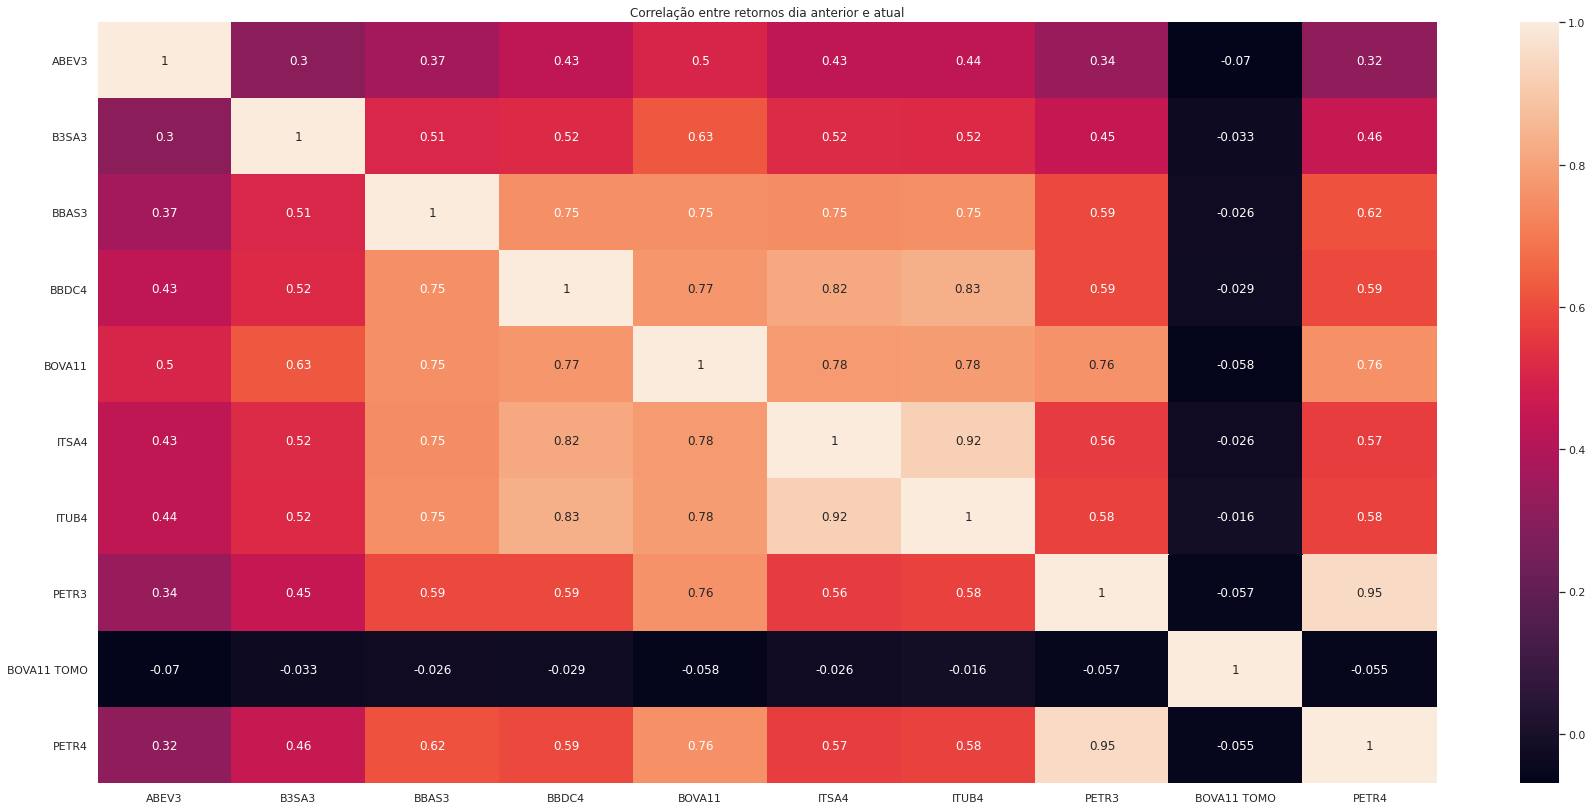

In [18]:
plt.title("Correlação entre retornos dia anterior e atual")
sns.heatmap(aux.corr(), annot = True);

Sepaando em teste e treinamento

In [29]:
def separacao(df1, df2, periodo = 360):
  df1_treinamento = df1.iloc[:len(df1)-periodo]
  df1_teste = df1.iloc[len(df1)-periodo:]

  df2_treinamento = df2.iloc[:len(df1)-periodo, :]
  df2_teste = df2.iloc[len(df1)-periodo:, :]

  return df1_treinamento, df1_teste, df2_treinamento, df2_teste


In [30]:
classe_treinamento, classe_teste, previsores_treinamento, previsores_teste = separacao(classe, previsores, periodo = 250)

In [41]:
def trade():
  #Rede Neural
  classificador = Sequential()
  classificador.add(Dense(units = 160, activation = 'tanh',
                          kernel_initializer = 'normal', 
                          input_dim = previsores_treinamento.shape[1])) 
  classificador.add(Dense(units = 80, activation = 'tanh',
                          kernel_initializer = 'normal'))
  classificador.add(Dense(units = 40, activation = 'tanh',
                          kernel_initializer = 'normal'))

  classificador.add(Dense(units = 1, activation = 'sigmoid'))

  classificador.compile(optimizer ='adam', loss= 'mse',
                        metrics = ['mae'])

  es = EarlyStopping(monitor = 'loss', min_delta = 1-10, patience = 50, verbose = 1) #para o treinamento caso não haja melhora na loss function
  rlr = ReduceLROnPlateau(monitor = 'loss', factor = 0.01, patience = 50, verbose = 1) #caso naão haja melhora na loss function, ele altera o gradiente 

  classificador.fit(previsores_treinamento, classe_treinamento,
                    batch_size = 21, epochs = 1000,
                    callbacks = [es, rlr])

  #resultados 
  previsoes = classificador.predict(previsores_teste)

  resultado = pd.DataFrame(np.where(previsoes > previsoes.mean(), 1, -1), columns=['regra'], index = classe_teste.index)
  resultado['Resultado'] = resultado['regra'] * classe_teste
  
  resultado['Resultado Acumulado'] = (1+resultado['Resultado']).cumprod()
  resultado['Resultado Acumulado'][0] = 1

  resultado['Retorno BOVA11 Acumulado'] = (1+classe_teste).cumprod()
  resultado['Retorno BOVA11 Acumulado'][0] = 1

  return resultado, previsoes, classificador

In [42]:
resultado, previsoes, classificador = trade()

Epoch 1/1000
119/119 [==============================] - 1s 3ms/step - loss: 0.0295 - mae: 0.0850
Epoch 2/1000
119/119 [==============================] - 0s 3ms/step - loss: 2.8468e-04 - mae: 0.0119
Epoch 3/1000
119/119 [==============================] - 0s 3ms/step - loss: 2.8233e-04 - mae: 0.0118
Epoch 4/1000
119/119 [==============================] - 0s 3ms/step - loss: 2.8036e-04 - mae: 0.0118
Epoch 5/1000
119/119 [==============================] - 0s 3ms/step - loss: 2.7882e-04 - mae: 0.0117
Epoch 6/1000
119/119 [==============================] - 0s 3ms/step - loss: 2.7765e-04 - mae: 0.0117
Epoch 7/1000
119/119 [==============================] - 0s 3ms/step - loss: 2.7676e-04 - mae: 0.0116
Epoch 8/1000
119/119 [==============================] - 0s 3ms/step - loss: 2.7607e-04 - mae: 0.0116
Epoch 9/1000
119/119 [==============================] - 0s 3ms/step - loss: 2.7552e-04 - mae: 0.0116
Epoch 10/1000
119/119 [==============================] - 0s 4ms/step - loss: 2.7508e-04 - mae: 

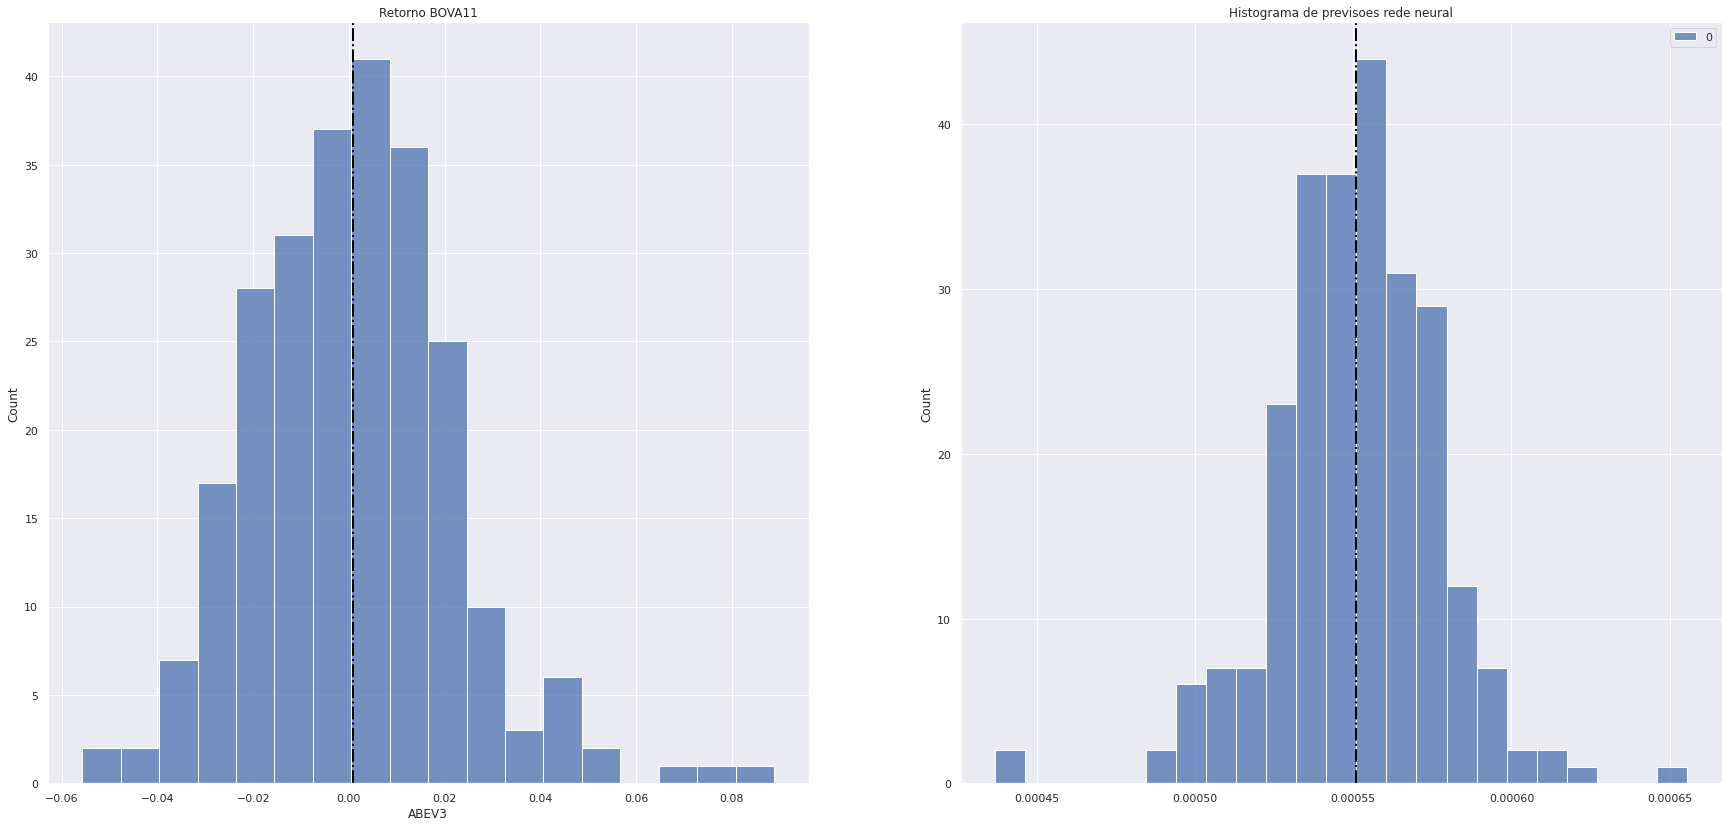

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 14))

sns.histplot(ax=ax1, data = classe_teste)
ax1.axvline(classe_teste.mean(), color = 'black', linestyle = '-.', linewidth = 2)
ax1.set_title("Retorno BOVA11");

sns.histplot(ax=ax2, data = previsoes)
ax2.axvline(previsoes.mean(), color = 'black', linestyle = '-.', linewidth = 2)
ax2.set_title("Histograma de previsoes rede neural");

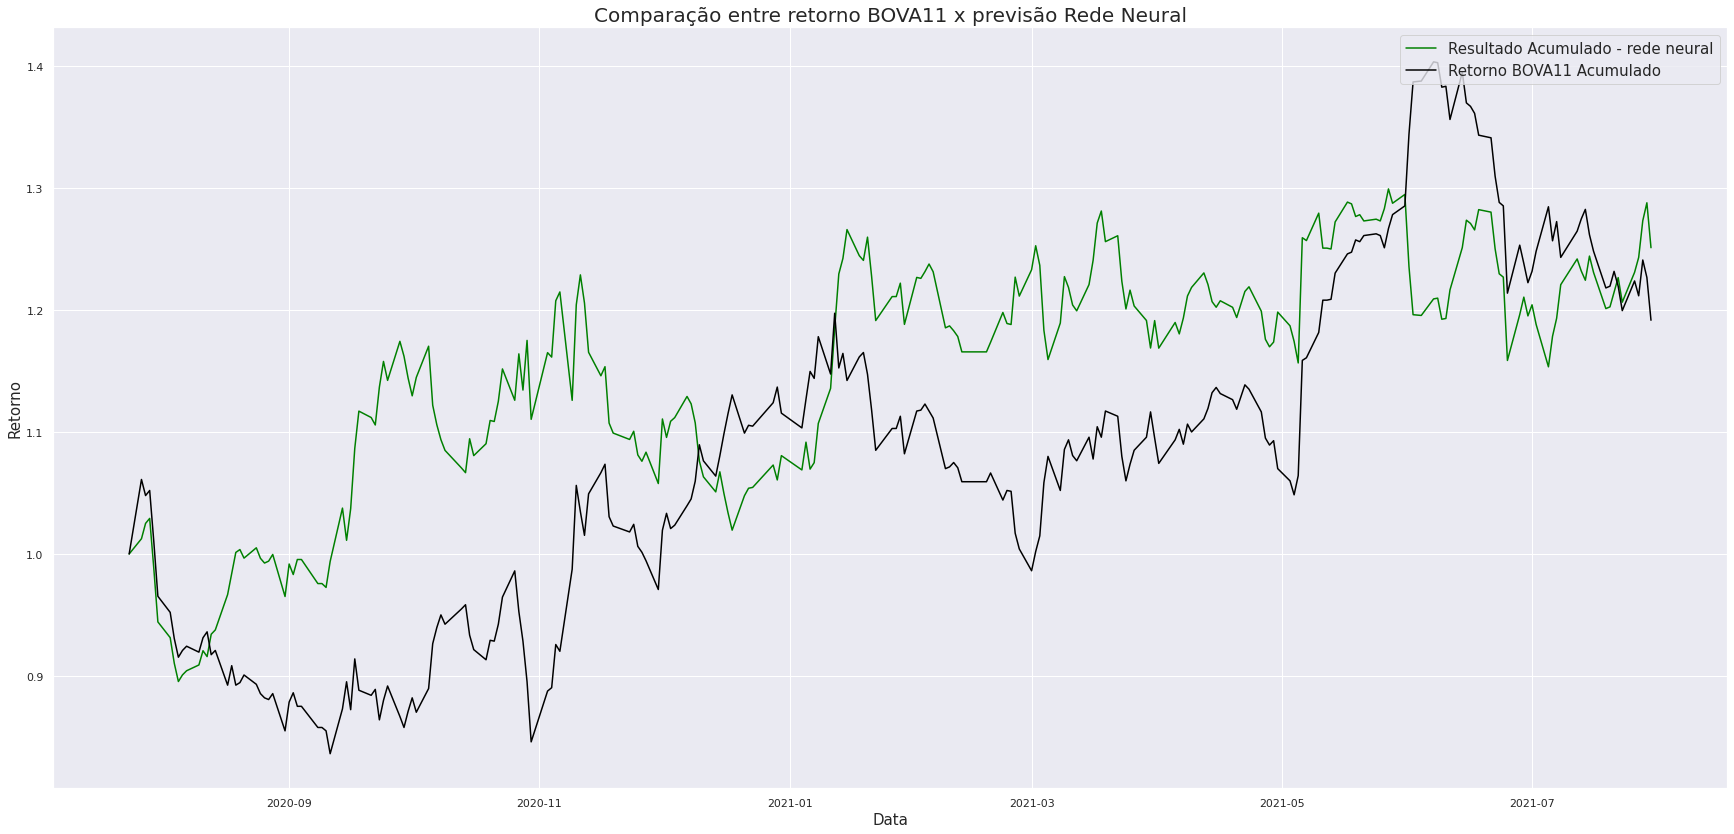

In [44]:
fig = plt.figure(figsize = (30,14))

plt.plot(resultado['Resultado Acumulado'],
         color = "green",
         label = "Resultado Acumulado - rede neural")

plt.plot(resultado['Retorno BOVA11 Acumulado'],
         color = "black",
         label = "Retorno BOVA11 Acumulado")

plt.xlabel('Data',
           fontsize = 15)
plt.ylabel('Retorno',
           fontsize = 15)
plt.legend(loc = 1,
           fontsize = 15)
plt.title("Comparação entre retorno BOVA11 x previsão Rede Neural",
          fontsize = 20);